In [1]:
import kagglehub
import shutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
from tqdm import tqdm
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## **Data Preprocessing dan Eksplorasi Data**

100%|██████████| 16.3M/16.3M [00:01<00:00, 9.37MB/s]

Extracting files...


Jumlah kelas: 10
Jumlah gambar per kelas:
  0: 205
  1: 206
  2: 206
  3: 206
  4: 207
  5: 207
  6: 207
  7: 206
  8: 208
  9: 204


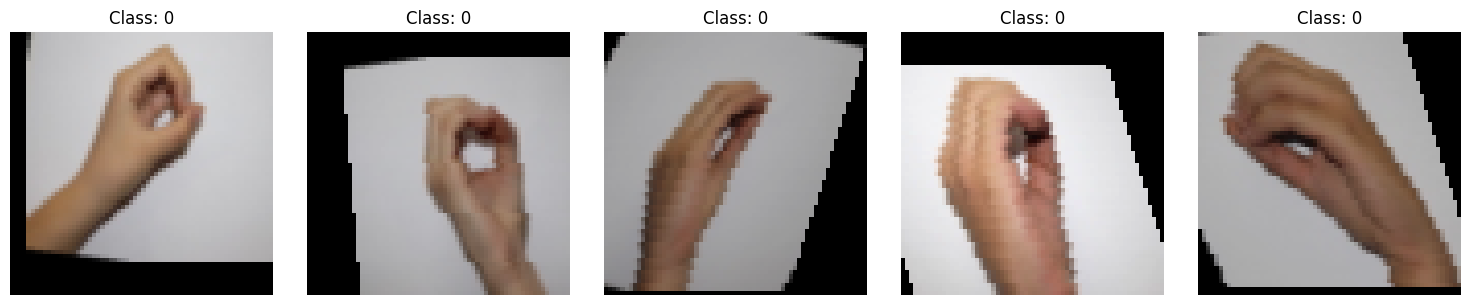

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data_dir = kagglehub.dataset_download("althafr/asl0-9")
extract_dir = './asl_dataset'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

for filename in os.listdir(data_dir):
    src_path = os.path.join(data_dir, filename)
    dst_path = os.path.join(extract_dir, filename)
    if os.path.isdir(src_path):
        shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
    else:
        shutil.copy2(src_path, dst_path)

transform = transforms.Compose([
    transforms.Resize((224, 244)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(root='./asl_dataset/Dataset', transform=transform)

labels = [sample[1] for sample in dataset.samples]
num_classes = len(set(labels))
count_per_class = Counter(labels)

print("Jumlah kelas:", num_classes)
print("Jumlah gambar per kelas:")
for idx, count in count_per_class.items():
    print(f"  {dataset.classes[idx]}: {count}")

target_class = '0'
class_idx = dataset.class_to_idx[target_class]
samples_in_class = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    idx = samples_in_class[i]
    img, _ = dataset[idx]
    img = img.permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Class: {target_class}")
plt.tight_layout()
plt.show()

indices = list(range(len(dataset)))

train_idx, temp_idx, _, temp_labels = train_test_split(
    indices, labels, test_size=0.3, stratify=labels, random_state=42)

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_labels, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Fungsi - Fungsi**

- Membuat model
- optimizer
- training
- evaluasi
- visualisasi

In [3]:
def build_model(pretrained=False, num_classes=num_classes):
    if pretrained:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


def get_optimizer(model, optim_name='adam', lr=0.001):
    if optim_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optim_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("Optimizer tidak dikenali")


def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []}
    total_training_start = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loop.set_postfix(loss=loss.item())
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, print_result=False)
        epoch_duration = time.time() - epoch_start
        history['epoch_time'].append(epoch_duration)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_duration:.2f}s")
    total_training_time = time.time() - total_training_start
    print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
    return history


def evaluate(model, data_loader, criterion, device, print_result=True):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    avg_loss = val_loss / len(data_loader)
    if print_result:
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")
    return avg_loss, acc


def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()


def show_predictions(model, data_loader, class_names, device, max_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(16, 8))
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if images_shown >= max_images:
                    break
                plt.subplot(2, 4, images_shown + 1)
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5) + 0.5
                plt.imshow(img)
                color = 'green' if preds[i] == labels[i] else 'red'
                plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", color=color)
                plt.axis('off')
                images_shown += 1
            if images_shown >= max_images:
                break
    plt.tight_layout()
    plt.show()



def evaluate_test_metrics(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Menghitung classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

    # Menampilkan confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Mengembalikan hasil classification report dalam bentuk dictionary
    return report

## **Experiment 3 Skema :**

Epoch 30 :
*   Model 1 - ResNet18 No Pretrained, Optimizer Adam, Learning Rate 0.001
*   Model 2 - ResNet18 Pretrained, Optimizer Adam, Learning Rate 0.0005
*   Model 3 - ResNet18 No Pretrained, Optimizer SGD, Learning Rate 0.001





In [4]:
def run_experiment(config):
    print(f"\nRunning experiment: {config['name']}")
    model = build_model(pretrained=config['pretrained'], num_classes=num_classes)
    optimizer = get_optimizer(model, optim_name=config['optimizer'], lr=config['lr'])
    criterion = nn.CrossEntropyLoss()
    history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=config['epochs'])
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    return {
        'name': config['name'],
        'model': model,
        'history': history,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

configs = [
    {'name': 'Model 1 - ResNet18 No Pretrained, Adam, LR=0.001', 'pretrained': False, 'optimizer': 'adam', 'lr': 0.001, 'epochs': 30},
    {'name': 'Model 2 - ResNet18 Pretrained, Adam, LR=0.0005', 'pretrained': True, 'optimizer': 'adam', 'lr': 0.0005, 'epochs': 30},
    {'name': 'Model 3 - ResNet18 No Pretrained, SGD, LR=0.001', 'pretrained': False, 'optimizer': 'sgd', 'lr': 0.001, 'epochs': 30}
]

results = []
for config in configs:
    result = run_experiment(config)
    results.append(result)


Running experiment: Model 1 - ResNet18 No Pretrained, Adam, LR=0.001


[Epoch 1] Train Loss: 2.2339, Train Acc: 0.1788, Val Loss: 2.9946, Val Acc: 0.2362, Time: 9.44s


[Epoch 2] Train Loss: 1.6907, Train Acc: 0.3867, Val Loss: 1.5513, Val Acc: 0.4725, Time: 8.19s


[Epoch 3] Train Loss: 1.2296, Train Acc: 0.5599, Val Loss: 1.6420, Val Acc: 0.5178, Time: 8.03s


[Epoch 4] Train Loss: 1.1087, Train Acc: 0.6098, Val Loss: 1.0512, Val Acc: 0.5922, Time: 7.47s


[Epoch 5] Train Loss: 0.9009, Train Acc: 0.6812, Val Loss: 1.5596, Val Acc: 0.5340, Time: 8.20s


[Epoch 6] Train Loss: 0.8041, Train Acc: 0.7332, Val Loss: 1.3735, Val Acc: 0.5599, Time: 7.24s


[Epoch 7] Train Loss: 0.8035, Train Acc: 0.7637, Val Loss: 1.0933, Val Acc: 0.6408, Time: 8.10s


[Epoch 8] Train Loss: 0.7058, Train Acc: 0.7741, Val Loss: 0.7437, Val Acc: 0.6861, Time: 8.22s


[Epoch 9] Train Loss: 0.5491, Train Acc: 0.8011, Val Loss: 0.6063, Val Acc: 0.8026, Time: 8.95s


[Epoch 10] Train Loss: 0.4551, Train Acc: 0.8552, Val Loss: 0.4826, Val Acc: 0.8479, Time: 8.12s


[Epoch 11] Train Loss: 0.4538, Train Acc: 0.8635, Val Loss: 0.5276, Val Acc: 0.8252, Time: 8.14s


[Epoch 12] Train Loss: 0.4320, Train Acc: 0.8607, Val Loss: 0.5021, Val Acc: 0.8317, Time: 7.38s


[Epoch 13] Train Loss: 0.3605, Train Acc: 0.8815, Val Loss: 0.3065, Val Acc: 0.8964, Time: 8.21s


[Epoch 14] Train Loss: 0.3278, Train Acc: 0.9106, Val Loss: 1.0322, Val Acc: 0.7314, Time: 7.28s


[Epoch 15] Train Loss: 0.5091, Train Acc: 0.8489, Val Loss: 0.5735, Val Acc: 0.8285, Time: 7.78s


[Epoch 16] Train Loss: 0.4231, Train Acc: 0.8766, Val Loss: 0.3535, Val Acc: 0.8673, Time: 8.00s


[Epoch 17] Train Loss: 0.5009, Train Acc: 0.8365, Val Loss: 0.4320, Val Acc: 0.8511, Time: 7.11s


[Epoch 18] Train Loss: 0.3177, Train Acc: 0.8954, Val Loss: 0.3023, Val Acc: 0.8932, Time: 8.47s


[Epoch 19] Train Loss: 0.2651, Train Acc: 0.9085, Val Loss: 0.4389, Val Acc: 0.8673, Time: 6.75s


[Epoch 20] Train Loss: 0.2278, Train Acc: 0.9300, Val Loss: 0.4116, Val Acc: 0.8511, Time: 7.77s


[Epoch 21] Train Loss: 0.4252, Train Acc: 0.8593, Val Loss: 0.2507, Val Acc: 0.9288, Time: 7.72s


[Epoch 22] Train Loss: 0.2823, Train Acc: 0.9099, Val Loss: 0.4441, Val Acc: 0.8544, Time: 6.82s


[Epoch 23] Train Loss: 0.4195, Train Acc: 0.8843, Val Loss: 0.4278, Val Acc: 0.8706, Time: 7.60s


[Epoch 24] Train Loss: 0.3384, Train Acc: 0.8905, Val Loss: 0.2056, Val Acc: 0.9385, Time: 6.81s


[Epoch 25] Train Loss: 0.1889, Train Acc: 0.9397, Val Loss: 0.1769, Val Acc: 0.9417, Time: 7.69s


[Epoch 26] Train Loss: 0.1735, Train Acc: 0.9446, Val Loss: 0.1883, Val Acc: 0.9288, Time: 7.14s


[Epoch 27] Train Loss: 0.1657, Train Acc: 0.9529, Val Loss: 0.3005, Val Acc: 0.9061, Time: 7.56s


[Epoch 28] Train Loss: 0.1730, Train Acc: 0.9459, Val Loss: 0.1190, Val Acc: 0.9579, Time: 7.86s


[Epoch 29] Train Loss: 0.1848, Train Acc: 0.9501, Val Loss: 0.2174, Val Acc: 0.9288, Time: 6.93s


[Epoch 30] Train Loss: 0.2588, Train Acc: 0.9203, Val Loss: 0.2973, Val Acc: 0.9126, Time: 7.74s

Total Training Time: 232.71 seconds
Validation Loss: 0.2782, Accuracy: 0.9126

Running experiment: Model 2 - ResNet18 Pretrained, Adam, LR=0.0005


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


[Epoch 1] Train Loss: 1.3378, Train Acc: 0.5440, Val Loss: 1.1576, Val Acc: 0.6667, Time: 7.47s


[Epoch 2] Train Loss: 0.6823, Train Acc: 0.7637, Val Loss: 0.4150, Val Acc: 0.8608, Time: 7.02s


[Epoch 3] Train Loss: 0.6612, Train Acc: 0.8025, Val Loss: 0.2496, Val Acc: 0.9126, Time: 7.60s


[Epoch 4] Train Loss: 0.4290, Train Acc: 0.8683, Val Loss: 0.3009, Val Acc: 0.8997, Time: 6.75s


[Epoch 5] Train Loss: 0.4657, Train Acc: 0.8572, Val Loss: 0.3148, Val Acc: 0.8964, Time: 7.65s


[Epoch 6] Train Loss: 0.4350, Train Acc: 0.8697, Val Loss: 0.1990, Val Acc: 0.9288, Time: 6.85s


[Epoch 7] Train Loss: 0.2514, Train Acc: 0.9258, Val Loss: 0.2089, Val Acc: 0.9320, Time: 7.68s


[Epoch 8] Train Loss: 0.2736, Train Acc: 0.9106, Val Loss: 0.2796, Val Acc: 0.9061, Time: 7.54s


[Epoch 9] Train Loss: 0.2066, Train Acc: 0.9349, Val Loss: 0.1346, Val Acc: 0.9612, Time: 6.76s


[Epoch 10] Train Loss: 0.1671, Train Acc: 0.9515, Val Loss: 0.2691, Val Acc: 0.9061, Time: 7.55s


[Epoch 11] Train Loss: 0.2902, Train Acc: 0.9272, Val Loss: 0.1961, Val Acc: 0.9353, Time: 6.82s


[Epoch 12] Train Loss: 0.2700, Train Acc: 0.9245, Val Loss: 0.1894, Val Acc: 0.9320, Time: 7.58s


[Epoch 13] Train Loss: 0.2114, Train Acc: 0.9307, Val Loss: 0.1632, Val Acc: 0.9417, Time: 6.76s


[Epoch 14] Train Loss: 0.2218, Train Acc: 0.9480, Val Loss: 0.1337, Val Acc: 0.9547, Time: 7.54s


[Epoch 15] Train Loss: 0.2001, Train Acc: 0.9376, Val Loss: 0.1176, Val Acc: 0.9644, Time: 7.66s


[Epoch 16] Train Loss: 0.2106, Train Acc: 0.9550, Val Loss: 0.1512, Val Acc: 0.9482, Time: 6.79s


[Epoch 17] Train Loss: 0.1995, Train Acc: 0.9390, Val Loss: 0.1109, Val Acc: 0.9709, Time: 7.59s


[Epoch 18] Train Loss: 0.1124, Train Acc: 0.9688, Val Loss: 0.0609, Val Acc: 0.9773, Time: 6.74s


[Epoch 19] Train Loss: 0.1474, Train Acc: 0.9626, Val Loss: 0.1104, Val Acc: 0.9709, Time: 7.61s


[Epoch 20] Train Loss: 0.1616, Train Acc: 0.9508, Val Loss: 0.0579, Val Acc: 0.9838, Time: 6.86s


[Epoch 21] Train Loss: 0.1747, Train Acc: 0.9480, Val Loss: 0.1172, Val Acc: 0.9547, Time: 7.48s


[Epoch 22] Train Loss: 0.1183, Train Acc: 0.9633, Val Loss: 0.1173, Val Acc: 0.9676, Time: 7.58s


[Epoch 23] Train Loss: 0.1089, Train Acc: 0.9709, Val Loss: 0.0623, Val Acc: 0.9838, Time: 6.78s


[Epoch 24] Train Loss: 0.1030, Train Acc: 0.9647, Val Loss: 0.0885, Val Acc: 0.9709, Time: 8.44s


[Epoch 25] Train Loss: 0.0852, Train Acc: 0.9716, Val Loss: 0.0659, Val Acc: 0.9773, Time: 6.70s


[Epoch 26] Train Loss: 0.1024, Train Acc: 0.9813, Val Loss: 0.1313, Val Acc: 0.9676, Time: 8.11s


[Epoch 27] Train Loss: 0.2990, Train Acc: 0.9092, Val Loss: 0.1090, Val Acc: 0.9676, Time: 6.71s


[Epoch 28] Train Loss: 0.2233, Train Acc: 0.9473, Val Loss: 0.1191, Val Acc: 0.9579, Time: 9.14s


[Epoch 29] Train Loss: 0.1814, Train Acc: 0.9383, Val Loss: 0.0918, Val Acc: 0.9838, Time: 7.52s


[Epoch 30] Train Loss: 0.1529, Train Acc: 0.9556, Val Loss: 0.1160, Val Acc: 0.9709, Time: 6.67s

Total Training Time: 219.96 seconds
Validation Loss: 0.1005, Accuracy: 0.9644

Running experiment: Model 3 - ResNet18 No Pretrained, SGD, LR=0.001


[Epoch 1] Train Loss: 2.3880, Train Acc: 0.0977, Val Loss: 2.3435, Val Acc: 0.1133, Time: 7.59s


[Epoch 2] Train Loss: 2.3403, Train Acc: 0.1199, Val Loss: 2.3469, Val Acc: 0.1165, Time: 6.61s


[Epoch 3] Train Loss: 2.3247, Train Acc: 0.1074, Val Loss: 2.3152, Val Acc: 0.1359, Time: 7.44s


[Epoch 4] Train Loss: 2.2860, Train Acc: 0.1400, Val Loss: 2.2301, Val Acc: 0.1909, Time: 7.29s


[Epoch 5] Train Loss: 2.2323, Train Acc: 0.1760, Val Loss: 2.1625, Val Acc: 0.2330, Time: 6.89s


[Epoch 6] Train Loss: 2.1427, Train Acc: 0.2259, Val Loss: 2.0624, Val Acc: 0.2816, Time: 7.40s


[Epoch 7] Train Loss: 1.9756, Train Acc: 0.3035, Val Loss: 1.8665, Val Acc: 0.3883, Time: 6.92s


[Epoch 8] Train Loss: 1.8253, Train Acc: 0.3756, Val Loss: 1.7339, Val Acc: 0.3560, Time: 7.39s


[Epoch 9] Train Loss: 1.5891, Train Acc: 0.4477, Val Loss: 1.5206, Val Acc: 0.4757, Time: 6.61s


[Epoch 10] Train Loss: 1.4190, Train Acc: 0.4906, Val Loss: 1.3652, Val Acc: 0.5146, Time: 7.49s


[Epoch 11] Train Loss: 1.3265, Train Acc: 0.5523, Val Loss: 1.2230, Val Acc: 0.5858, Time: 7.14s


[Epoch 12] Train Loss: 1.2015, Train Acc: 0.5807, Val Loss: 1.0905, Val Acc: 0.6278, Time: 6.97s


[Epoch 13] Train Loss: 1.0785, Train Acc: 0.6202, Val Loss: 1.3106, Val Acc: 0.5469, Time: 7.40s


[Epoch 14] Train Loss: 0.9960, Train Acc: 0.6618, Val Loss: 0.8845, Val Acc: 0.7152, Time: 6.64s


[Epoch 15] Train Loss: 0.9559, Train Acc: 0.6632, Val Loss: 1.1657, Val Acc: 0.5890, Time: 7.38s


[Epoch 16] Train Loss: 0.8685, Train Acc: 0.7152, Val Loss: 0.7904, Val Acc: 0.7217, Time: 6.63s


[Epoch 17] Train Loss: 0.8494, Train Acc: 0.6999, Val Loss: 1.3079, Val Acc: 0.5437, Time: 7.41s


[Epoch 18] Train Loss: 0.7615, Train Acc: 0.7471, Val Loss: 0.8137, Val Acc: 0.7152, Time: 6.92s


[Epoch 19] Train Loss: 0.7291, Train Acc: 0.7415, Val Loss: 0.7565, Val Acc: 0.7249, Time: 7.26s


[Epoch 20] Train Loss: 0.6527, Train Acc: 0.7623, Val Loss: 0.9865, Val Acc: 0.6634, Time: 7.45s


[Epoch 21] Train Loss: 0.6301, Train Acc: 0.7928, Val Loss: 0.6069, Val Acc: 0.7896, Time: 6.63s


[Epoch 22] Train Loss: 0.6095, Train Acc: 0.7810, Val Loss: 0.5576, Val Acc: 0.8091, Time: 7.37s


[Epoch 23] Train Loss: 0.5769, Train Acc: 0.8087, Val Loss: 0.5462, Val Acc: 0.8058, Time: 6.51s


[Epoch 24] Train Loss: 0.5571, Train Acc: 0.8087, Val Loss: 0.4894, Val Acc: 0.8285, Time: 7.37s


[Epoch 25] Train Loss: 0.5322, Train Acc: 0.8226, Val Loss: 0.5945, Val Acc: 0.7864, Time: 6.56s


[Epoch 26] Train Loss: 0.5314, Train Acc: 0.8115, Val Loss: 0.5363, Val Acc: 0.7864, Time: 7.37s


[Epoch 27] Train Loss: 0.5056, Train Acc: 0.8344, Val Loss: 0.5089, Val Acc: 0.8252, Time: 7.15s


[Epoch 28] Train Loss: 0.4977, Train Acc: 0.8351, Val Loss: 0.4576, Val Acc: 0.8350, Time: 6.80s


[Epoch 29] Train Loss: 0.4805, Train Acc: 0.8420, Val Loss: 0.4684, Val Acc: 0.8155, Time: 7.36s


[Epoch 30] Train Loss: 0.4598, Train Acc: 0.8462, Val Loss: 0.4168, Val Acc: 0.8608, Time: 6.63s

Total Training Time: 212.57 seconds
Validation Loss: 0.3464, Accuracy: 0.8673


### **Evaluasi dan Visualisasi Perbandingan**


Evaluasi untuk Model 1 - ResNet18 No Pretrained, Adam, LR=0.001:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.94      1.00      0.97        31
           2       0.91      1.00      0.95        31
           3       0.88      0.90      0.89        31
           4       0.96      0.81      0.88        31
           5       0.96      0.87      0.92        31
           6       1.00      0.94      0.97        31
           7       0.83      0.94      0.88        31
           8       0.91      0.97      0.94        31
           9       0.97      0.90      0.93        31

    accuracy                           0.93       310
   macro avg       0.94      0.93      0.93       310
weighted avg       0.94      0.93      0.93       310



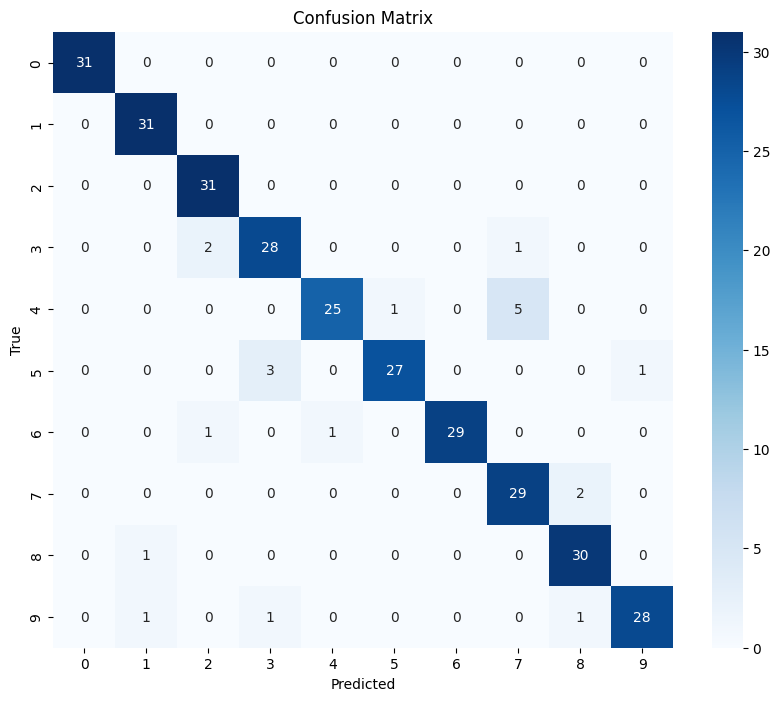


Evaluasi untuk Model 2 - ResNet18 Pretrained, Adam, LR=0.0005:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        31
           2       0.94      1.00      0.97        31
           3       0.97      0.90      0.93        31
           4       0.91      1.00      0.95        31
           5       1.00      1.00      1.00        31
           6       1.00      0.97      0.98        31
           7       0.94      1.00      0.97        31
           8       1.00      0.90      0.95        31
           9       0.97      0.94      0.95        31

    accuracy                           0.97       310
   macro avg       0.97      0.97      0.97       310
weighted avg       0.97      0.97      0.97       310



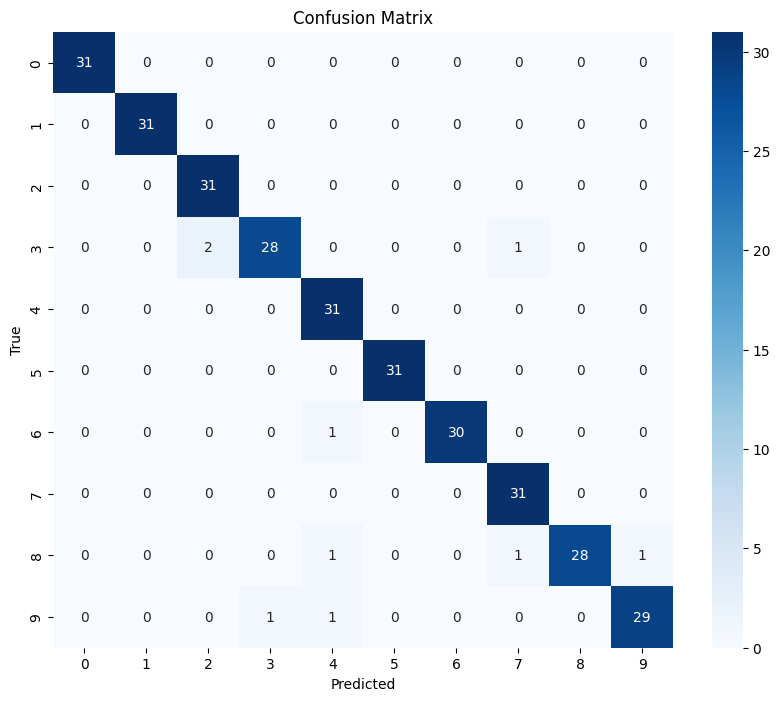


Evaluasi untuk Model 3 - ResNet18 No Pretrained, SGD, LR=0.001:

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.97      0.98        31
           2       0.76      0.94      0.84        31
           3       0.83      0.77      0.80        31
           4       0.92      0.71      0.80        31
           5       0.91      1.00      0.95        31
           6       0.72      0.84      0.78        31
           7       0.69      0.71      0.70        31
           8       0.81      0.84      0.83        31
           9       0.96      0.71      0.81        31

    accuracy                           0.85       310
   macro avg       0.86      0.85      0.85       310
weighted avg       0.86      0.85      0.85       310



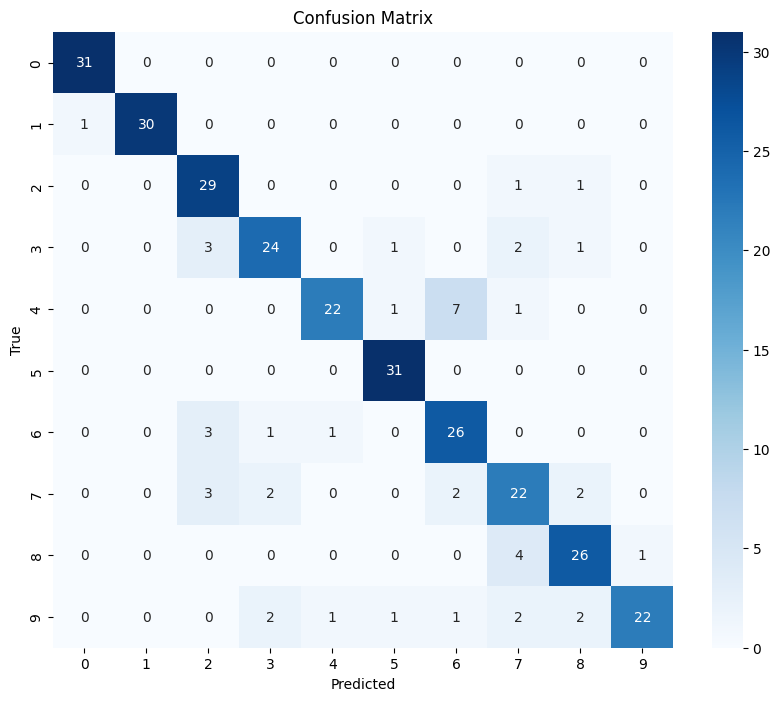

In [5]:
for result in results:
    print(f"\nEvaluasi untuk {result['name']}:")
    evaluate_test_metrics(result['model'], test_loader, device, dataset.classes)

In [6]:
# Pilih model dengan val_acc terbaik
best_model_result = max(results, key=lambda x: x['val_acc'])
print(f"\nModel terbaik: {best_model_result['name']} dengan val accuracy {best_model_result['val_acc']:.4f}")

# Simpan model terbaik ke file
torch.save(best_model_result['model'].state_dict(), "best_model.pth")
print("Model terbaik berhasil disimpan ke file 'best_model.pth'")



Model terbaik: Model 2 - ResNet18 Pretrained, Adam, LR=0.0005 dengan val accuracy 0.9644
Model terbaik berhasil disimpan ke file 'best_model.pth'
